In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score
from interpret.glassbox import ExplainableBoostingRegressor
from interpret import show

Matplotlib is building the font cache; this may take a moment.


In [2]:
# LOADING DATA

data = pd.read_excel('final_dataset.xlsx')

data

,Unnamed: 0,STATE_CODE,SHRP_ID,YEAR,CONSTRUCTION_NO,MAX_MEAN_DEPTH_1_8,ANL_KESAL_LTPP_LN_YR,TOTAL_ANN_PRECIP,FREEZE_INDEX_YR,MAX_ANN_TEMP_AVG,MAX_ANN_TEMP_DAYS,DAYS_ABOVE_32_C_YR,MR_MATL_TYPE,RES_MOD_AVG,REPR_THICKNESS
0,0,37,1024,1992,1,9,80,1471.300049,11,19.799999,366,2,2,21,NaN
1,1,37,1024,1992,1,9,80,1471.300049,11,19.799999,366,2,2,19,NaN
2,2,37,1024,1992,1,9,80,1471.300049,11,19.799999,366,2,2,77,NaN
3,3,37,1024,1992,1,9,80,1471.300049,11,19.799999,366,2,2,79,NaN
4,4,37,1024,1992,1,9,80,1471.300049,11,19.799999,366,2,2,95,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21751,21751,28,3082,1992,1,5,107,1240.800049,12,22.100000,366,17,2,115,NaN
21752,21752,28,3082,1992,1,5,107,1240.800049,12,22.100000,366,17,2,89,NaN
21753,21753,28,3082,1992,1,5,107,1240.800049,12,22.100000,366,17,2,134,NaN
21754,21754,28,3082,1992,1,5,107,1240.800049,12,22.100000,366,17,2,117,NaN


In [3]:
# Data Preprocessing
# Drop any unnamed columns if they exist
unnamed_cols = [col for col in data.columns if 'Unnamed' in col]
if unnamed_cols:
    data.drop(unnamed_cols, inplace=True, axis=1)

# Check for duplicates and remove them
data.drop_duplicates(inplace=True)

# Check for missing values
print("Missing values in each column:")
print(data.isnull().sum())

Missing values in each column:
STATE_CODE                 0
SHRP_ID                    0
YEAR                       0
CONSTRUCTION_NO            0
MAX_MEAN_DEPTH_1_8         0
ANL_KESAL_LTPP_LN_YR       0
TOTAL_ANN_PRECIP           0
FREEZE_INDEX_YR            0
MAX_ANN_TEMP_AVG           0
MAX_ANN_TEMP_DAYS          0
DAYS_ABOVE_32_C_YR         0
MR_MATL_TYPE               0
RES_MOD_AVG                0
REPR_THICKNESS          5362
dtype: int64


In [4]:
# Fill missing values with mean for REPR_THICKNESS if needed
if data['REPR_THICKNESS'].isnull().sum() > 0:
    data.fillna(data['REPR_THICKNESS'].mean(), inplace=True)

data

,STATE_CODE,SHRP_ID,YEAR,CONSTRUCTION_NO,MAX_MEAN_DEPTH_1_8,ANL_KESAL_LTPP_LN_YR,TOTAL_ANN_PRECIP,FREEZE_INDEX_YR,MAX_ANN_TEMP_AVG,MAX_ANN_TEMP_DAYS,DAYS_ABOVE_32_C_YR,MR_MATL_TYPE,RES_MOD_AVG,REPR_THICKNESS
0,37,1024,1992,1,9,80,1471.300049,11,19.799999,366,2,2,21,97.883721
1,37,1024,1992,1,9,80,1471.300049,11,19.799999,366,2,2,19,97.883721
2,37,1024,1992,1,9,80,1471.300049,11,19.799999,366,2,2,77,97.883721
3,37,1024,1992,1,9,80,1471.300049,11,19.799999,366,2,2,79,97.883721
4,37,1024,1992,1,9,80,1471.300049,11,19.799999,366,2,2,95,97.883721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21750,28,3082,1992,1,5,107,1240.800049,12,22.100000,366,17,2,105,97.883721
21751,28,3082,1992,1,5,107,1240.800049,12,22.100000,366,17,2,115,97.883721
21752,28,3082,1992,1,5,107,1240.800049,12,22.100000,366,17,2,89,97.883721
21753,28,3082,1992,1,5,107,1240.800049,12,22.100000,366,17,2,134,97.883721


In [5]:

# Feature Selection
# X: input variables
X = data.loc[:,[
    'CONSTRUCTION_NO',
    'ANL_KESAL_LTPP_LN_YR',
    'TOTAL_ANN_PRECIP',
    'FREEZE_INDEX_YR',
    'MAX_ANN_TEMP_AVG',
    'MAX_ANN_TEMP_DAYS',
    'DAYS_ABOVE_32_C_YR',
    'MR_MATL_TYPE',
    'RES_MOD_AVG',
    'REPR_THICKNESS'
]]

# y: output predictor
y = data.loc[:,['MAX_MEAN_DEPTH_1_8']]

In [9]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")

# Create and train EBM model
# Documentation: https://interpret.ml/docs/ebm.html
# High-performance EBM configuration
print("Training Optimized Explainable Boosting Machine model...")
start_time = time.time()

# Key Parameters for High-Performance EBM:
ebm_model = ExplainableBoostingRegressor(
    # Much higher iteration count for more thorough learning
    max_rounds=5000,
    
    # More complex interaction modeling
    interactions=20,
    
    # Higher resolution binning for better capturing continuous relationships
    max_bins=512,
    
    # More bagging for better stability
    outer_bags=32,
    inner_bags=4,
    
    # Smaller learning rate for more refined convergence
    learning_rate=0.005,
    
    # Balance between greedy and cyclic boosting
    greedy_ratio=15.0,
    
    # More smoothing to capture complex relationships
    smoothing_rounds=1000,
    
    # Extended patience for optimal convergence
    early_stopping_rounds=200,
    
    # Smaller leaf samples for more detailed trees
    min_samples_leaf=2,
    
    # Extended validation splitting
    validation_size=0.2,
    
    # Random seed for reproducibility
    random_state=42
)

# Train the optimized model
ebm_model.fit(X_train, y_train.values.ravel())
training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

Training set shape: (4427, 10), (4427, 1)
Testing set shape: (1107, 10), (1107, 1)
Training Optimized Explainable Boosting Machine model...
Training completed in 447.80 seconds


In [11]:
# Model Evaluation
# Predictions
y_pred_train = ebm_model.predict(X_train)
y_pred_test = ebm_model.predict(X_test)

# Calculate metrics
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)

print("\nModel Performance:")
print(f"Training R²: {train_r2:.4f}")
print(f"Testing R²: {test_r2:.4f}")
print(f"Training MSE: {train_mse:.4f}")
print(f"Testing MSE: {test_mse:.4f}")

# Cross Validation
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
cv_scores = cross_val_score(ebm_model, X_train, y_train.values.ravel(), cv=cv)
print(f"\nCross Validation R² (mean): {cv_scores.mean():.4f}")
print(f"Cross Validation R² (std): {cv_scores.std():.4f}")


Model Performance:
Training R²: 0.9680
Testing R²: 0.9511
Training MSE: 0.4121
Testing MSE: 0.5726


KeyboardInterrupt: 

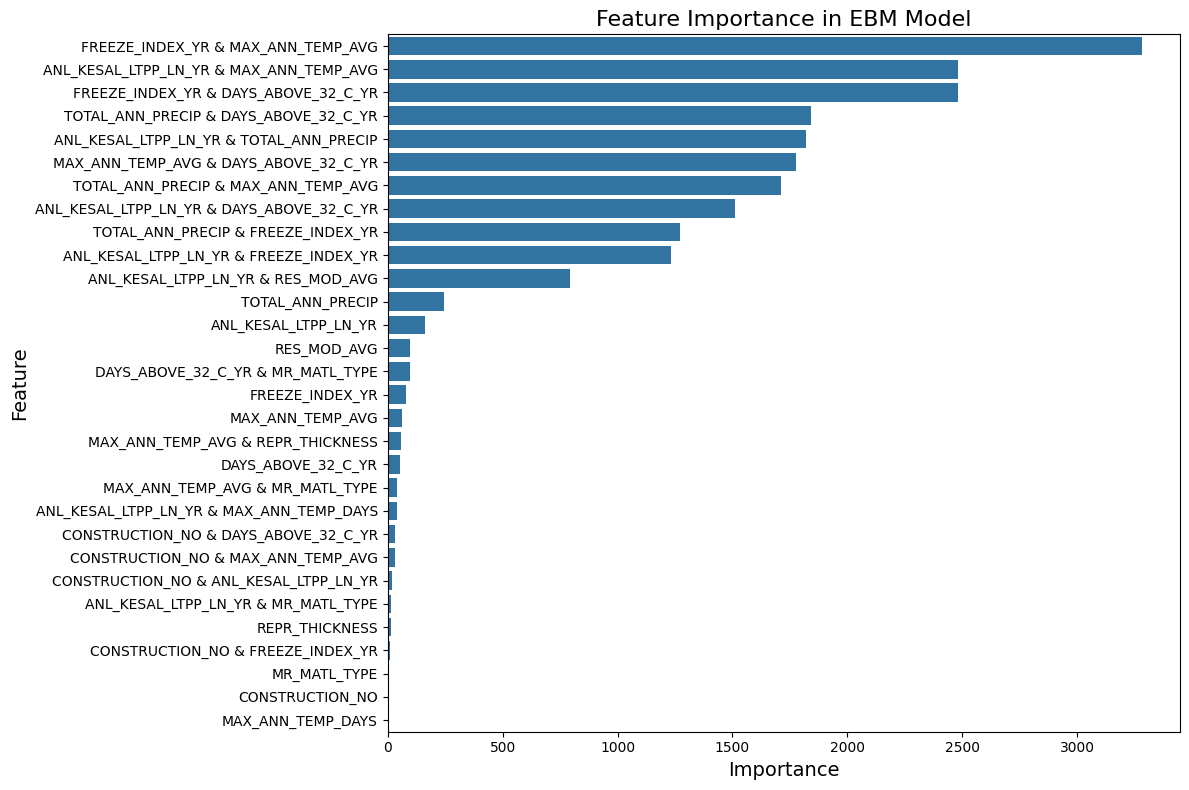

In [15]:
# Correct approach that works with EBM's structure
plt.figure(figsize=(12, 8))

# Get the global explanation
global_explanation = ebm_model.explain_global()

# Extract feature names and their importance directly from the explanation object
feature_names = global_explanation.feature_names
# Get importance for main effects only (no interactions)
importances = np.array([abs(global_explanation.data(i)['scores']).sum() 
                        for i in range(len(feature_names))])

# Create DataFrame for easier plotting
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# Sort by importance
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Create the plot
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance in EBM Model', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.savefig('ebm_feature_importance.png', dpi=300)
plt.show()